In [1]:
import pandas as pd
import numpy as np
from recommender_metrics.plots import LongTailPlot, CoveragePlot, MarkPlot
from recommender_metrics.metrics import mark, coverage, diversity, serendipity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over 1000 movies
users = ratings.userId.value_counts()
users = users[users>1000].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


# Long Tail Plot Example

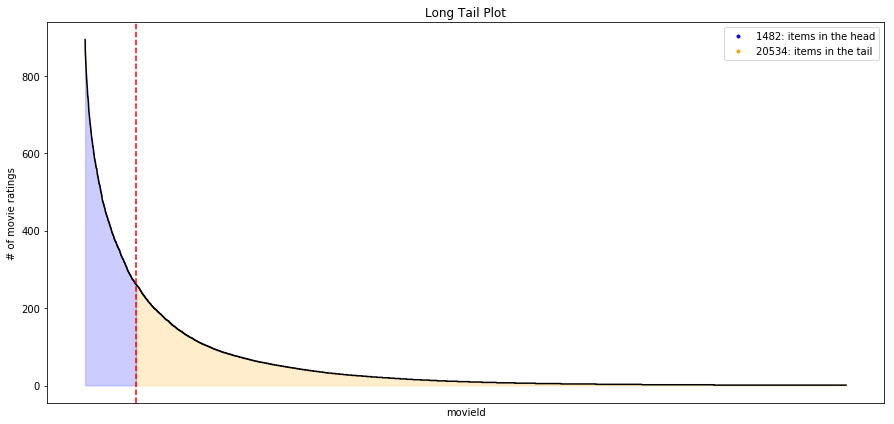

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
    
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Simple Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

## test/train split

In [6]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recommender_metrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[5292, 4117, 541, 544, 34, 5382, 4646, 2095, 5..."
208,"[1537, 6659, 44555, 527, 17, 539, 34338, 6195,..."
359,"[514, 6149, 34319, 31251, 42004, 1047, 1049, 2..."
394,"[6659, 26116, 5641, 1546, 6671, 1042, 4116, 54..."
572,"[2053, 3087, 55830, 4632, 4641, 56367, 2616, 5..."


In [7]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


## Popularity Recommendations

In [8]:
#make popularity recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
156,"[5292, 4117, 541, 544, 34, 5382, 4646, 2095, 5...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5..."
208,"[1537, 6659, 44555, 527, 17, 539, 34338, 6195,...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5..."
359,"[514, 6149, 34319, 31251, 42004, 1047, 1049, 2...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5..."
394,"[6659, 26116, 5641, 1546, 6671, 1042, 4116, 54...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5..."
572,"[2053, 3087, 55830, 4632, 4641, 56367, 2616, 5...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5..."


In [9]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Collaborative Filter

In [10]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131168,131174,131176,131231,131239,131241,131248,131250,131254,131256
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,0.0,3.0,3.0,4.0,4.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [12]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131168,131174,131176,131231,131239,131241,131248,131250,131254,131256
156,4.370181,4.200356,1.173986,2.426841,1.816393,3.295564,4.113949,0.805556,1.667893,3.660941,...,-0.003395,-0.030653,-0.039411,-0.040264,-0.007945,-0.007945,-0.007945,-0.007945,-0.007945,-0.007945
208,3.444994,0.181937,-0.581069,0.279061,-0.129648,0.529848,0.016473,0.127385,0.164321,-0.129175,...,-0.004797,0.011087,0.014254,0.015522,-0.015630,-0.015630,-0.015630,-0.015630,-0.015630,-0.015630
359,4.646255,2.092999,0.450288,-0.084666,0.693665,4.109522,1.136496,-0.140067,0.233501,2.442226,...,0.003421,-0.012053,-0.015497,-0.035732,0.003525,0.003525,0.003525,0.003525,0.003525,0.003525
394,3.047033,0.356581,0.093462,-0.291562,0.584884,1.378240,0.465893,0.097270,0.156512,1.027134,...,-0.016835,-0.015094,-0.019407,-0.025153,-0.030976,-0.030976,-0.030976,-0.030976,-0.030976,-0.030976
572,3.520982,2.246389,2.150311,-0.341555,2.266963,1.126574,0.527057,0.248679,0.185374,1.405344,...,0.009198,0.044008,0.056582,-0.018628,-0.004694,-0.004694,-0.004694,-0.004694,-0.004694,-0.004694


## Collaborative Filter Recommendations

In [13]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [14]:
get_users_predictions(156, 10, cf_model, train_long)

[3361, 3702, 592, 4855, 3494, 1687, 3708, 3468, 1721, 423]

In [15]:
#make popularity recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,cf_predictions
userId,,,
156,"[5292, 4117, 541, 544, 34, 5382, 4646, 2095, 5...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[3361, 3702, 592, 4855, 3494, 1687, 3708, 3468..."
208,"[1537, 6659, 44555, 527, 17, 539, 34338, 6195,...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[3362, 3083, 1307, 44555, 235, 3359, 2858, 206..."
359,"[514, 6149, 34319, 31251, 42004, 1047, 1049, 2...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[6539, 36529, 47610, 1127, 7090, 318, 34319, 3..."
394,"[6659, 26116, 5641, 1546, 6671, 1042, 4116, 54...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[296, 1449, 3996, 720, 5060, 994, 541, 745, 28..."
572,"[2053, 3087, 55830, 4632, 4641, 56367, 2616, 5...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[1265, 44191, 48516, 3087, 1961, 500, 5445, 29..."


In [16]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [88]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007931404072883172,
 0.0011414790996784566,
 0.0014165773490532334,
 0.001590746695248303,
 0.0017600928903179708,
 0.0018904966059306895,
 0.00204055019649875,
 0.0021611289746337977,
 0.0022528283910920564,
 0.002363224961295701]

In [89]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.008017148981779205,
 0.014833869239013933,
 0.020800285816362986,
 0.026371025366202214,
 0.03171722043586995,
 0.03664576634512326,
 0.04132498851630685,
 0.045707357219415094,
 0.04996363922489324,
 0.05387789431599721]

In [90]:
cf_scaled_mark = []
for K in np.arange(1, 11):
    cf_scaled_mark.extend([mark(actual, cf_scaled_predictions, k=K)])
cf_scaled_mark

[0.004072883172561629,
 0.00654876741693462,
 0.008467309753483386,
 0.009844587352625939,
 0.011212218649517686,
 0.012359056806002142,
 0.013391058030929414,
 0.014326213443576789,
 0.01512530835842733,
 0.015912017897548442]

# Mark Plot

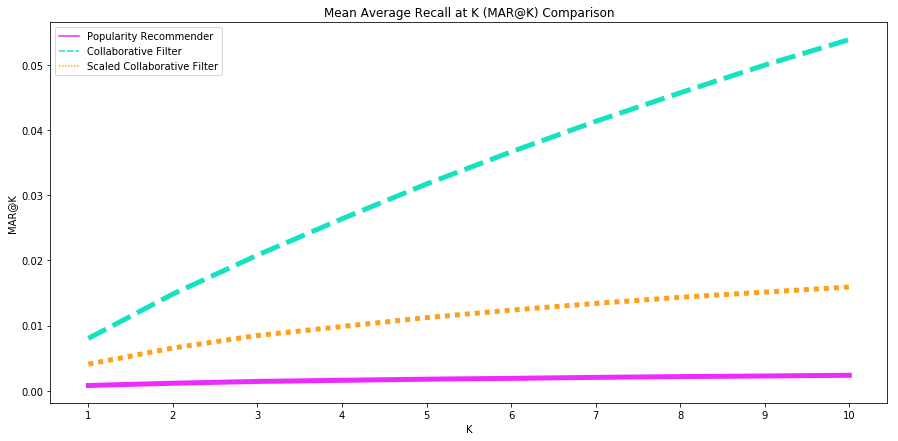

In [91]:
mark_scores = [pop_mark, cf_mark, cf_scaled_mark]
index = range(1,10+1)
names = ['Popularity Recommender', 'Collaborative Filter', 'Scaled Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [92]:
catalog = train_long.movieId.unique().tolist()
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)
cf_scaled_coverage = coverage(cf_scaled_predictions, catalog)

# Coverage Plot

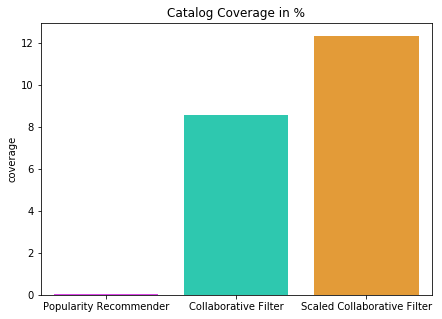

In [93]:
coverage_scores = [pop_coverage, cf_coverage, cf_scaled_coverage]
model_names = ['Popularity Recommender', 'Collaborative Filter', 'Scaled Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

# Diveristy

In [32]:
# TO DO
add intralist diversity
and add a method for bubbling up diverse products

SyntaxError: invalid syntax (<ipython-input-32-f3d68f944bf7>, line 2)

# Serendipity

In [ ]:
add method for bubbling up serendipitous recs

# Item precision and recall

In [ ]:
# add Predicted rating distripution plot by movie id
# Add function to adjust predicted rating dby volume

In [86]:
import seaborn as sns

def ScoresDistributionPlot(train, item_id, model):
    users_who_liked = train.query('movieId == @item_id').userId.unique().tolist()
    users_who_did_not_like = train.query('movieId != @item_id').userId.unique().tolist()

    predicted_movie_ratings_1 = model.loc[users_who_liked,item_id]
    predicted_movie_ratings_2 = model.loc[users_who_did_not_like,item_id]
    ax = sns.distplot(predicted_movie_ratings_1, color="red",label="derp", bins=5)
    ax = sns.distplot(predicted_movie_ratings_2, color="blue",label="derp", bins=25)
    
    plt.show()

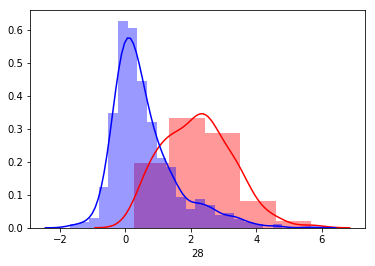

In [87]:
item_id = 28

ScoresDistributionPlot(train_longngong, item_id, cf_model)

In [82]:
def adjust_rec_score(item_id, model, train):
    users = train.query('movieId == @item_id').userId.unique().tolist() #users in test who rated this movie
    true_scores = model.loc[users_who_liked,item_id]

    scores_mean = np.mean(true_scores)
    threshold = 3-scores_mean
    
    new_scores = model.loc[:,item_id]+threshold
    return new_scores

In [57]:
# Find all products not in coverage
cf_predicted_flattened = [p for sublist in cf_predictions for p in sublist]
unique_predictions = list(set(cf_predicted_flattened))

# all items in train
train_items = pd.Series(volume.index.values)

#all items from train in not in coverage
items_not_covered = train_items[~train_items.isin(unique_predictions)].unique().tolist()
print len(items_not_covered)

19896


In [83]:
#adjust_rec_score(28, cf_model, train_long)
cf_scaled_model = cf_model.copy()

for item_id in items_not_covered:
    cf_scaled_model.loc[:,item_id] = adjust_rec_score(item_id, cf_model, train_long)

In [84]:
#make popularity recommendations for all members in the test data

recs = []
for user in user_index:
    cf_scaled_predictions = get_users_predictions(user, 10, cf_scaled_model, train_long)
    recs.append(cf_scaled_predictions)
        
test['cf_scaled_predictions'] = recs
test.head()

,actual,pop_predictions,cf_predictions,cf_scaled_predictions
userId,,,,
156,"[5292, 4117, 541, 544, 34, 5382, 4646, 2095, 5...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[3361, 3702, 592, 4855, 3494, 1687, 3708, 3468...","[2533, 3802, 1833, 2531, 3264, 479, 2263, 3744..."
208,"[1537, 6659, 44555, 527, 17, 539, 34338, 6195,...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[3362, 3083, 1307, 44555, 235, 3359, 2858, 206...","[3925, 3747, 2677, 96488, 3700, 112552, 32943,..."
359,"[514, 6149, 34319, 31251, 42004, 1047, 1049, 2...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[6539, 36529, 47610, 1127, 7090, 318, 34319, 3...","[6618, 8370, 6283, 27788, 3972, 6322, 7324, 87..."
394,"[6659, 26116, 5641, 1546, 6671, 1042, 4116, 54...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[296, 1449, 3996, 720, 5060, 994, 541, 745, 28...","[5385, 296, 8228, 1202, 6584, 38304, 5288, 562..."
572,"[2053, 3087, 55830, 4632, 4641, 56367, 2616, 5...","[1198, 1270, 593, 2571, 318, 608, 2762, 260, 5...","[1265, 44191, 48516, 3087, 1961, 500, 5445, 29...","[40614, 1265, 45062, 58803, 71379, 4084, 42730..."


In [85]:
cf_scaled_predictions = test.cf_scaled_predictions.values.tolist()

In [ ]:
# idea
To simuate and prove pop bias in mar@k and map@k
1. train one CF on movielnese pop data,  all movies with volume over 1000

2. and anotehr on downsampled movielense data with ewual volume of all movies. 
all movies with volume over 1000 and downsaple volume of every movie to 1000 

Show coverage of each model

Show mar@k and map@k. Item level p and r. coverage. 
volume dist of recs from each model. 